Use kernel `papi-advanced`

## AI: Machine Learning & Deep Learning

In this lesson, we will explore how to apply machine learning (ML) methods to image analysis. 


---

### Machine Learning

In classical programming, you either write explicit rules yourself (e.g., if-statements, fixed thresholds) or use predefined algorithms (like Otsu’s method, which automatically determines a threshold) — in both cases, you feed in data and get answers, without the system “learning” from the data itself.

In ML, you feed in data and the **computer learns the rules automatically**.
- *Supervised learning*: You give the computer examples and the correct answers. It learns the pattern between them.
    - Example: you show images of cells and say “these are dividing” and “these are not.” The computer learns to tell them apart.
- *Unsupervised learning*: No examples. The computer looks for structure or clusters (things that look alike).
    - Example: it might notice that some cells are rounder and dimmer, others are brighter and irregular (dividing), and group them without you telling it what they mean.


**Classical ML**: Uses hand-crafted features — such as area, intensity, or texture — that are picked by humans. The algorithm (e.g., Random Forest, SVM, k-Means, Logistic Regression) then learns how to combine these features to make decisions.

**DL** (a specialized branch of ML): Learns features directly from raw data (like images or signals) without manual feature selection. The model automatically discovers which patterns are most relevant for the task.

We will try two applications of ML:

**Object Classification:** 
In this approach, we first detect and measure all individual objects, and then train a ML model to classify each object into predefined categories — for example, distinguishing between Healthy and Apoptotic Cells.
We will use the **scikit-learn** library, which provides a wide range of classical machine learning algorithms such as Random Forests and Support Vector Machines.

**Pixel Classification (Segmentation)**: 
We teach the ML model to assign a class label to every single pixel in the image — for instance, separating Nucleus, Cytoplasm, and Background.
For this, we will use the **apoc** library, which offers an easy-to-use interface to scikit-learn–based classifiers, accelerated with GPU computing via pyclesperanto.

---

#### Object classification - scikit learn

In this exercise, we will tackle a common problem in cell analysis: classifying cells into different populations based on their measured properties.

Simple scenario - we have 2 features (area and intensity) and annotated data (supervised)

We have a dataset of cells with their Area and Intensity measured. We can see from a scatter plot that there are likely separable into two distinct populations. Our goal is to find the line that best separates them.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/cell_simple_measurements.csv')

# Let's visualize our starting data
plt.figure(figsize=(6, 4))
plt.scatter(df["Area"], df["Intensity"], c=df["Label"], cmap="coolwarm", alpha=0.6)
plt.xlabel("Area")
plt.ylabel("Intensity")
plt.show()

Let's try to separate these two populations with a simple line. 

A line is defined by the equation: y = a*x + b, which for us is:
```Intensity = slope * Area + intercept```

Do not worry to much about the code below. We use ipywidgets to create interactive plot.

Your task now is to use the sliders associated with the plot to change the slope and intercept of the line. 

The goal is to move the line so that it gives the best possible separation between the two cell populations.

In [ ]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display


def interactive_classifier(df):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(df["Area"], df["Intensity"], c=df["Label"], cmap="coolwarm", alpha=0.6)
    ax.set_xlabel("Area")
    ax.set_ylabel("Intensity")
    ax.set_ylim(df['Intensity'].min() - 10, df['Intensity'].max() + 10)

    # Line
    x_vals = np.linspace(df["Area"].min(), df["Area"].max(), 400)
    line, = ax.plot(x_vals, np.zeros_like(x_vals), 'k--', lw=1)

    # Sliders
    slope_slider = widgets.FloatSlider(value=0, min=-3, max=3, step=0.05, description="slope")
    intercept_slider = widgets.FloatSlider(value=110, min=90, max=300, step=2, description="intercept")

    # Update function
    def update(change=None):
        slope = slope_slider.value
        intercept = intercept_slider.value
        line.set_ydata(slope * x_vals + intercept)
        ax.set_title(f'Intensity = {slope:.2f} * Area + {intercept:.1f}')
        fig.canvas.draw_idle()

    # Connect sliders
    slope_slider.observe(update, names='value')
    intercept_slider.observe(update, names='value')

    # Display widgets
    display(widgets.VBox([slope_slider, intercept_slider]))

    # Draw initial line
    update()


interactive_classifier(df)


Finding the best line by hand is subjective and time-demanding. This is exactly the kind of problem machine learning is designed to solve! 

We will now use a Support Vector Machine (SVM), a classic machine learning algorithm, to find the optimal separating line automatically.

Workflow:
- Step 1: Prepare the data 
- Step 2: Train the machine learning model
- Step 3: Apply the model on other data

##### Step 1: Prepare the data 

The package we are using expects the data to be in specific format:
- X: A 2D array-like structure containing the features (our Area and Intensity columns) - can be DataFrame
- y: A 1D array-like structure containing the target labels (our Label column).

In [ ]:
# Prepare the feature matrix X
X = df[['Area', 'Intensity']]

# Prepare the target vector y
y = df['Label']

##### Step 2: Train the machine learning model

SVM is a machine learning method that tries to find the boundary (a line, or a plane in higher dimensions) that best separates the data into different classes.
It does this by maximizing the margin — the distance between the boundary and the closest data points from each class, known as the support vectors.

SVC (Support Vector Classifier) is the specific implementation of SVM used for classification tasks.

In our example, we’ll create an SVC with a linear kernel, which means we ask the model to find a straight-line boundary between classes.
The command `model.fit(X, y)` is where the SVC learns this boundary from the data.




In [ ]:
# Create an instance of the linear SVM classifier
from sklearn.svm import SVC # Support Vector Classifier

# Prepare model
model = SVC(kernel='linear')

# Train the model on our data
model.fit(X, y)

After training, the model stores:
- Weights (**w**) and bias (**b**): together, they define both the slope and the intercept of the separating line.

The SVM decision boundary in this case is mathematically defined as:
`w1*x + w2*y + b = 0`

In [ ]:
# Get the parameters

# Our model stores the line parameters in .coef_ and .intercept_
w = model.coef_[0] # a vector of weights [w₁, w₂] representing the contribution of each feature to the boundary
b = model.intercept_[0] # a scalar b representing the bias

# We can rearrange this to the familiar format: y = slope*x + intercept 
# w1*x + w2*y + b = 0    →     y = -(w1/w2)*x - b/w2
slope_ml = -w[0] / w[1]
intercept_ml = -b / w[1]
equation = f'Intensity = {slope_ml:.2f} * Area + {intercept_ml:.1f}'
print(equation)

Let's plot the decision boundary.

- In order to add lines to plots, we generate a vector of x values
    - here 100 values linearly distributed between the minimum and maximum of Area values
    - `x_vals = np.linspace(df['Area'].min(), df['Area'].max(), 100)`
- And then we use the equation to compute vector of corresponding y values.
    - `y_vals = slope_ml * x_vals + intercept_ml`

In [ ]:
%matplotlib inline
plt.close('all')
 
# Plot 
x_vals = np.linspace(df['Area'].min(), df['Area'].max(), 100)
y_vals = slope_ml * x_vals + intercept_ml

plt.figure(figsize=(6, 4))
plt.scatter(df["Area"], df["Intensity"], c=df["Label"], cmap="coolwarm", alpha=0.6)
plt.plot(x_vals, y_vals, color='black', linestyle=':', linewidth=2, label='SVM Decision Boundary')
plt.xlabel("Area")
plt.ylabel("Intensity")
plt.legend()
plt.show()

##### Step 3: Apply the model on other data

We will read new measurements. 

To apply our classifier model, we again need to prepare data. This time we only need the feature matrix - X.

Apply the model to get prediction simply with `model.predict(X)`.

In [ ]:
# Apply it on new data

df_new = pd.read_csv('../data/cell_simple_measurements2.csv')

X_new = df_new[['Area', 'Intensity']]

# Use the .predict() method on the trained model
new_predictions = model.predict(X_new)

Predictions are simply an array with the same number of rows as the input feature matrix X.

We can add them to our second dataframe as a new column.

In [ ]:
# Add these predictions as a new column in our new DataFrame for easy analysis and plotting
df_new['Predicted_Label'] = new_predictions

df_new.head()

Plot the result of our classification together with the decision boundary. 

In [ ]:
# Generate x values based on the new data's Area range
x_vals_new = np.linspace(df_new['Area'].min(), df_new['Area'].max(), 100)
# Compute corresponding y values using the trained model's slope and intercept
y_vals_new = slope_ml * x_vals_new + intercept_ml


# Plot befor and after classification 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Left Plot: Before Classification ---
axes[0].scatter(df_new["Area"], df_new["Intensity"], alpha=0.6)
axes[0].set_title("Before Classification")

# --- Right Plot: After Classification ---
axes[1].scatter(df_new["Area"], df_new["Intensity"], c=df_new["Predicted_Label"], cmap="coolwarm", alpha=0.6)
axes[1].plot(x_vals_new, y_vals_new, color="black", linestyle="--", label="Decision Boundary")
axes[1].set_title("After Classification")
axes[1].legend()

plt.show()


#### Classifying Real-World Cell Data

In our previous example, we could clearly see the separation between our two classes with just two features. Real-world biological data is often much more complex.

A More Realistic Scenario:

- **High-Dimensional Features:** We often measure dozens of properties for each cell (area, intensity, perimeter, and many complex shape and texture features). This creates a "high-dimensional" feature space that is impossible to visualize directly.

- **Unknown Feature Importance:** We don't know ahead of time which of these dozens of features are actually useful for separating our cell populations. Is it area? eccentricity? A combination of three different texture features?

- **Non-Linear Separability:** The boundary between the classes is rarely a simple straight line. It might be a curve, a complex shape, or completely intertwined.

To solve this, we need a more powerful and flexible machine learning model.

---

**The Random Forest Classifier**

For this kind of complex, tabular data, one of the best and most popular "go-to" classifiers is the Random Forest.

How it works (conceptually): Instead of learning one simple rule (like a line), it builds hundreds of simple "decision trees" (like flowcharts). Each tree gets a random subset of the data and features to train on. To make a final prediction, all the trees "vote," and the majority class wins.

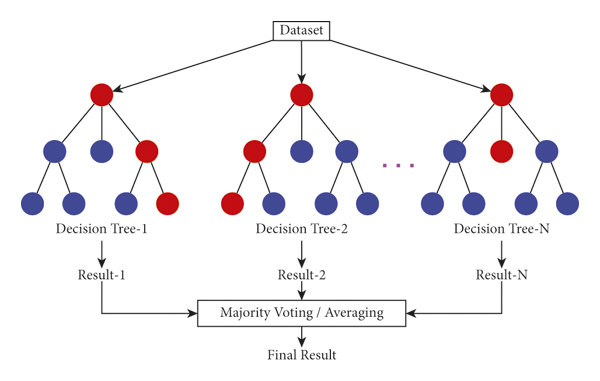


---

##### --- Exercise: Classifying Cells with RandomForest model ---

You are given two datasets (as Pandas DataFrames) containing multiple features (shape, size, intensity) calculated by skimage.regionprops.
- **ground_truth_df**: A table of measurements for 100 cells that have been expertly annotated by a biologist as either "Healthy" or "Cancer". This is your training data.
- **unannotated_df**: A larger table of measurements for 500 new cells from a different experiment. Your goal is to predict which of these are cancerous.

Your Task:
1. Read DataFrames from csv files and explore the training data.
    - Let's use seaborn.pairplot to see the relationships between all our features, colored by the ground truth label.
    - ```python sns.pairplot(ground_truth_df, hue='label')```

2. Train a RandomForestClassifier on the ground_truth_df.
    - extract the feature matrix (as `X_train`) and labels (as `y_train`)
    - load the model and optionaly set parameters (function `RandomForestClassifier()`)
        - use `help()` to investigate the function and inquiry about its parameters
        - set number of decifion trees to 200
        - set `random_state` to any number - what it does?
        - set argument `oob_score` as `True` to calculate out-of-bag (OOB) accuracy
    - use fit to train the model (`model.fit(X_train, y_train)`)
    - print thw oob accuracy score (`model.oob_score_`)

3. Apply the trained model to predict the class for every cell in unannotated_df.
    - Visualize the classification on the new data with seaborn pairplot (do not forget to add predictions to the unannotated_df)

4. Determine which features the model found the most important.
    - use `model.feature_importances_` to get importance scores (the order is same as the order of features given to model)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

GT_df_path = '../data/ml_ground_truth_cells.csv'
U_df_path = '../data/ml_unannotated_cells.csv'


<details>
<summary>Click to see the example solution</summary>

```python
# EXAMPLE SOLUTION

import seaborn as sns

# --- Read dataframes and make pairplot ---
ground_truth_df = pd.read_csv(GT_df_path)
unannotated_df = pd.read_csv(U_df_path)

print(ground_truth_df.head(n=3), '\n') # optionally check data
print(unannotated_df.head(n=3), '\n') # optionally check data


sns.pairplot(ground_truth_df, hue='label', palette='bwr')
plt.show()

# --- Prepare the training data ---
# Extract the wanted columns 
feature_columns = [col for col in ground_truth_df.columns if col != 'label']
X_train = ground_truth_df[feature_columns]
# The 'label' column is what we want to predict
y_train = ground_truth_df['label']


# --- Initialize and train the Random Forest ---
# `n_estimators` is the number of decision trees in the forest
# `random_state` ensures that the results are reproducible.
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")
# out-of-bag accuracy of the model
print('out-of-bag accuracy: ', rf_model.oob_score_)


# --- Make predictions on other DataFrame ---
# Prepare the unannotated data for prediction
# It's crucial that we use the same feature columns in the same order
X_unannotated = unannotated_df[feature_columns]

# Predict
predictions = rf_model.predict(X_unannotated)

# Add the predictions as a new column to our unannotated DataFrame
unannotated_df['predicted_label'] = predictions

# Visualize results
sns.pairplot(unannotated_df, hue='predicted_label', palette='bwr') 
plt.show()

# --- Determine the feature importances ---
# We could guess from the pairplot, that 'mean_intensity_ch2' seems to be the biggest driver
print('Feature importances')
importances = rf_model.feature_importances_
for feature, importance in zip(feature_columns, importances):
    print(f"{feature}: {importance:.3f}")

# Optional: bar plot
sns.barplot(x=importances, y=feature_columns)
plt.title("Feature Importances")
plt.show()
```

---

### Pixel classification (semantic segmentation)

Now, we will move to pixel classification. This technique, also called semantic segmentation, is useful for segmenting complex images where simple thresholding fails.

How does this relate to our previous classification?
- Object Classification works on a table of features. Its input is a DataFrame, and its output is a list of predictions for each row (object).
- Pixel Classification works directly on an image. Its input is the image itself, and its output is a new "label image" where every pixel has been assigned a class.

In this exercise we will work from scratch (no annotations). We will leverage the **Napari** as an interactive annotation tool to 'paint' our training data." 


**Segmenting a DIC Image**

We will work with a sample transmitted-light image (DIC) containing roundish cells.
Separating these cells using traditional thresholding methods is very difficult, since each cell contains both bright and dark regions.

The Machine Learning Approach:
1. **Annotation**: 

    We first prepare a mask by manually painting a few pixels for each class.
    In this example, we will define two classes: foreground (cells) and background
2. **Feature Selection**: 

    Next, we choose which image features the classifier will use as input.
    These features are not object-level measurements, but filtered versions of the image—such as Gaussian blur, difference of Gaussians, or other filters that highlight structural details.
3. **Training**: 

    A classifier (such as a Random Forest) learns how the image features correspond to the class labels we defined during annotation.
4. **Prediction**: 

    The trained classifier then predicts the class (foreground or background) for every pixel in the image—and can even be applied to new, unseen images.

Load image and inspect its properties

In [ ]:
from skimage import io

image_path = "../data/cho08.png"
image = io.imread(image_path)
print('image shape: ', image.shape, '\ndtype: ', image.dtype)

In [ ]:
plt.imshow(image, cmap='gray')

In [ ]:
# plot image histogram

plt.hist(image.ravel(), bins=256)
plt.show()

Then we'll open **Napari** and add our image. 

We'll also create an empty "Labels" layer, which we will use to "paint" our annotations directly in the GUI.

In [ ]:
import napari 

# Launch the Napari viewer
viewer = napari.Viewer()

# Add the image to the viewer
viewer.add_image(image, name='Cell Image')

# Create an empty label array (same shape as the image)
# The label layer will store manual annotations (e.g., foreground/background)
# Note: labels must be integer type
annotations_layer = viewer.add_labels(np.zeros(image.shape, dtype=np.uint32), name='Annotations')

**Annotation**

Now, go to the **Napari** window that popped up. This is an interactive step.

*Instructions:*
- Select the Annotations layer in the layer list.
- In the layer controls panel, select the paint brush tool.
- Set the label number to 1. Use the paintbrush to paint a few small, representative regions of the background.
- Change the label number to 2. Paint over a few of the cells. You don't need to be perfect or cover the whole cell, just give the algorithm some examples.

    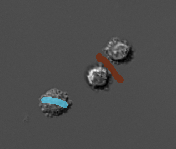

**Retrieve Annotations**

Once finished, we read the modified label array back to notebok.

In [ ]:
# Retrieve data from the manually painted annotation layer
ground_truth_labels = viewer.layers['Annotations'].data

# Check if we have labels for 2 classes
# Label '0' represents unlabeled pixels and will be ignored by the classifier
unique_labels = np.unique(ground_truth_labels)
print(f"Labels found in our annotations: {unique_labels}")


**Select Features and Train the Classifier**

We need to tell the classifier what kind of features to compute for each pixel. This is done by providing a *feature string* that defines a sequence of image processing operations. Based on these features, the classifier learns to distinguish between different regions in the image using our annotations.

Typical features include image filters such as **Gaussian blur**, **Laplacian**, or **edge detectors (Sobel)**, which capture variations in intensity, texture, and structure.
The chosen range of **sigma values** or **kernel sizes** helps the classifier recognize objects at different scales or sizes.

In [ ]:
# Now, we train our pixel classifier
import apoc

# Define the features. We'll use a combination of blur and edge detection.
# This gives the classifier information about local intensity and texture.
# Sigma is set to 2
feature_definition = "gaussian_blur=2 sobel_of_gaussian_blur=2"

# Create a Pixel Classifier object.
# Apoc runs a RandomForrest algorithm, so you can define for example number of decision trees
# 'opencl_filename' defines the filename for saving the trained model.
classifier = apoc.PixelClassifier(opencl_filename="first_pixel_classifier.cl")

# Train the classifier.
# This may take a few seconds depending on image size and number of features.
classifier.train(features=feature_definition, ground_truth=ground_truth_labels, image=image)

print("\nClassifier training complete.")

**Prediction**

We will use the trained model to segment our input image.

The prediction is performed using:
```python
classifier.predict(features, image)
```
We specify the image to be segmented (i.e., the pixels to be classified) and provide the same feature set that was used during training.

The result will be a new label image where every pixel is assigned to either class 1 or class 2.

In [ ]:
# Predict the class for every pixel
prediction = classifier.predict(features=feature_definition, image=image)

# Add the prediction as a new labels layer in Napari
viewer.add_labels(prediction, name='Segmentation')

**Refinement**

There are two main ways to improve the classifier:

- Annotate more data
- Modify the input feature set

Try to go back to **Napari** and annotate more pixels in **Annotation** layer. Then re-run the code cells to retrieve Annotation layer data, train classifier and run prediction.

This iterative process helps the classifier learn more accurate patterns and produce better segmentation results.

**Inspect features**

You can visualize the features that will be used. 

In this example, we define a set of features and apply them to our image.

In [ ]:
# List of features
feature_list = [
    'gaussian_blur=2',
    'gaussian_blur=6',
    'difference_of_gaussian=2',
    'sobel_of_gaussian_blur=2',
    'median_box=2',
]

# Convert list to space-separated string for APOC
features = ' '.join(feature_list)

print(feature_list)
print(features)

In [ ]:
# Feed the feature string to apoc to generate feature stack
feature_stack = apoc.generate_feature_stack(image, features)


# Number of features
n_features = len(feature_stack)

# Plot
fig, axes = plt.subplots(n_features, 1, figsize=(4, 2*n_features))

for ax, feature, name in zip(axes, feature_stack, feature_list):
    ax.imshow(feature, cmap='gray')
    ax.set_title(f'{name}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

**Predefined feature sets**

APOC provides several predefined feature sets that you can use out of the box. They are optimized for example for objects of different sizes. [More info.](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20a_pixel_classification/feature_stacks.html?highlight=predefined)

Using a predefined feature set can save time and help you get started quickly, especially if you’re unsure which features will work best for your images.

In [ ]:
# We can also use predefined feature sets
features = apoc.PredefinedFeatureSet.medium_quick.value
print(features)

**Train classifier with pre-defined feature set**

We already have our Annotation layer, it is super easy now to train new classifier with different feature set.

In [ ]:
classifier = apoc.PixelClassifier(opencl_filename="second_pixel_classifier.cl")
classifier.train(features=features, ground_truth=ground_truth_labels, image=image)
prediction = classifier.predict(features=features, image=image)

plt.imshow(prediction, cmap='gray')

The code below prints all available predefined feature sets.

In [ ]:
# print all predefined feature sets

for featset in apoc.PredefinedFeatureSet:
    print(f'{featset.name} -- feature set: {featset.value}\n')

**Further analysis**

We classified cells and background, but both have a label value > 0.


To perform instance segmentation (i.e., extract individual cells), we need to further process the resulting mask.

In our case, the background has label 1, so we can create a binary mask for the cells simply by thresholding.

In [ ]:
# Thresholding
cells_mask = prediction>1

Let's count the number objects.

In [ ]:
from skimage import measure
cells_labels = measure.label(cells_mask)

# Variant A
# By getting max label value (can be incorrect when missing intermediate labels)
number_of_objects = cells_labels.max() 
print("cell count:", number_of_objects) 

# Variant B
# By counting unique lables
unique_labels = np.unique(cells_labels)
unique_labels = unique_labels[unique_labels != 0] # Exclude the background label (0)
number_of_objects = len(unique_labels)
print("cell count:", number_of_objects)

# Add labels to Napari
viewer.add_labels(cells_labels)

**Alternative: APOC Object Segmenter**

APOC also provides an Object Segmenter, which allows you to perform instance segmentation directly. This is an alternative to using classifier combined with connected components labeling (skimage.measure.label) on a binary mask. 

The workflow is very similar: you select features, build and train a classifier, and then predict labels for all objects in the image.


In [ ]:
# Object segmenter

# Select a predefined feature set
features = apoc.PredefinedFeatureSet.medium_quick.value

# Prepare the model
segmenter = apoc.ObjectSegmenter(opencl_filename='object_segmenter.cl', positive_class_identifier=2)

# Train the model
segmenter.train(features, ground_truth_labels, image)

# Predict
segmentation_result = segmenter.predict(features=features, image=image)
plt.imshow(segmentation_result)

---

##### ---  Exercise: Train a Pixel Classifier / Object Segmenter on a time-lapse image

**Steps:**

1. Load the image `mouse_SC.tif` from 'data' folder and check its dimensions.
   * Extract the first frame and store it in a new variable.
2. Create a separate Napari viewer instance (e.g. viewer2).
3. Send the first frame to Napari.
   * Crate an empty labels layer (either from the notebook or directly in the GUI).
4. In the labels layer make annotations for cells and background.
5. Pull the annotation layer back into the notebook and store it as `annotations`.
6. Use `annotations` and the frame image to train an **APOC PixelClassifier** or **ObjectSegmenter**.
    - Try to set the features to get good-loking segmentation results.
    - You can iteratively adjust features after prediction.
    - Example solution uses `apoc.PredefinedFeatureSet.medium_quick.value`.
7. Predict on the single frame to verify that the classifier has learned to segment cells.
8. Predict on all other frames of the time-lapse. 
9. Send both the full image stack and the predicted segmentation stack to Napari to inspect the results.
10. Count the number of detected objects per slice.
    - *Note:* If you used *PixelClassifier*, convert the predicted mask to a labeled image using `skimage.measure.label`.
11. Plot cell counts over time.

<details>
<summary>Click to see the example solution - steps 1-4</summary>

```python
# EXAMPLE SOLUTION

# --- Load image and check shape ---
image_stack = io.imread('../data/mouse_SC.tif')
print("Image shape:", image_stack.shape)

# --- Extract first timepoint and send to Napari ---
first_frame = image_stack[0]

viewer2 = napari.Viewer()
viewer2.add_image(first_frame, name='First Frame')

# Add empty annotation layer
annotations = viewer2.add_labels(np.zeros_like(first_frame, dtype=np.uint32), name='Annotations')

# --- Annotate in Napari GUI ---
# Manually paint a few cells and background
#
#
```
</details>

<details>
<summary>Click to see the example solution - steps 5 onward </summary>

```python
# --- Pull annotation layer back ---
annotations = viewer2.layers['Annotations'].data

# --- Train PixelClassifier ---
features = apoc.PredefinedFeatureSet.medium_quick.value
# set positive_class_identifier according to your labeling
clf = apoc.ObjectSegmenter(opencl_filename='exercise_segmenter.cl', positive_class_identifier=2)
clf.train(features=features, ground_truth=annotations, image=first_frame)

# --- Predict on first frame ---
predicted_mask = clf.predict(features=features, image=first_frame)
viewer2.add_labels(predicted_mask, name='Predicted Mask')


# --- Predict on all timepoints ---
segmentation_stack = []
for t in range(image_stack.shape[0]):
    pred = clf.predict(features=features, image=image_stack[t,:,:])
    segmentation_stack.append(pred)
segmentation_stack = np.array(segmentation_stack)

# --- Send the stacks to Napari
viewer2.add_image(image_stack, name='Image Stack')
viewer2.add_labels(segmentation_stack, name='Segmentation Stack')


# --- Count objects per slice ---
cell_counts = []
for t in range(segmentation_stack.shape[0]):
    labeled = measure.label(segmentation_stack[t] > 1)  # threshold background label 1
    cell_counts.append(labeled.max())

# --- Plot cell count over time ---
plt.figure(figsize=(6,4))
plt.plot(cell_counts, marker='o', linestyle='None')
plt.xlabel('Timepoint')
plt.ylabel('Number of cells')
plt.show()

# --- (alternative): Plot with Seaborn regression ---
import seaborn as sns
timepoints = np.arange(len(cell_counts))

plt.figure(figsize=(6,4))
sns.regplot(x=timepoints, y=cell_counts, marker='o', ci=None,)
plt.xlabel('Timepoint')
plt.ylabel('Number of cells')
plt.show()

```
</details>

---

### Tracking

Since we have segmented cells in a timelapse, lets track them!

**Tracking in Biology**

Tracking is the process of identifying and following individual objects (like cells, nuclei, or vesicles) through a sequence of images over time.

Tracking is a usually a two-step process:
- Detection: In every single frame of the movie, find all the objects of interest. 
    We just learned how to do this with our machine learning segmenter.
- Linking: Connect the detection of an object in one frame to the same object in the next frame to form a trajectory.

Example Python packages for tracking:

- **trackpy**:
    
    Implements a simple and robust linking algorithm.
    Easy to configure for basic timelapse tracking tasks.

- **btrack** (Bayesian Tracker)

    A more advanced, probabilistic (Bayesian) approach.
    Can handle complex events like splitting and merging of objects.


**Workflow**

We will now track cells in our time-lapse stack.

1. Detect (segment) objects (already done that).
    - You can use the segmentation you just created, or load ground truth (perfect) segmentations from file.
2. Measure object centroids - with skimage.measure.region_props
3. Link detections across frames - with trackpy
4. Visualize tracks in Napari

Load image and labels

In [ ]:
# Read labels from file
labels_path = r'../data/mouse_SC_labels.tif'
labels = io.imread(labels_path) # or set labels as your ML result

# Read image again
image_path = r'../data/mouse_SC.tif'
image_stack = io.imread(image_path)

import stackview
stackview.blend(image_stack, labels, colormap2='nipy_spectral')

Measure centroids of detected objects and store them in a DataFrame

In [ ]:
all_detections = []

for frame_index, single_frame_labels in enumerate(labels):
    if single_frame_labels.max() == 0: # avoid empty frames
        continue

    props = measure.regionprops_table(
        single_frame_labels,
        properties=('label', 'centroid', 'area')
    )
    frame_df = pd.DataFrame(props)
    frame_df['frame'] = frame_index

    all_detections.append(frame_df)

detections_df = pd.concat(all_detections, ignore_index=True)

# Formatting for trackpy
# `trackpy` requires specific column names: 'x', 'y', and 'frame'.
detections_df = detections_df.rename(columns={'centroid-0': 'y', 'centroid-1': 'x'})
detections_df

Linking Detections with trackpy

Next, we use `trackpy.link()` to connect the detected objects across frames into continuous trajectories.

We must must specify a maximum distance (`search_range`) that an object is allowed to move between consecutive frames.

Second, we set `memory` - the number of frames an object can temporarily disappear and still be linked to the same trajectory (e.g. due to disappearing from the field of view, or missed segmentation). 

In [ ]:
# Use trackpy to link detections into trajectories

import trackpy as tp 

# search_range = max distance a cell can travel between frames
tracks_df = tp.link(detections_df, search_range=100, memory=3)

# We will get back a pandas DataFrame with extra column
tracks_df

Visualize tracks in Napari

Create a Napari viewer and visualize tracks on top of our data.

In [ ]:
viewer = napari.Viewer()

viewer.add_image(image_stack, name='image')
viewer.add_labels(labels, name='labels')

In [ ]:
# Add the tracks. 
# Napari's `.add_tracks()` can work with pandas DataFrames!
track_data = tracks_df[['particle', 'frame', 'y', 'x']]
viewer.add_tracks(track_data, name='Tracks')

You can play with the Track layer controls in Napari to adjust the visualization.

In [ ]:
napari.utils.nbscreenshot(viewer)

<br><br>

---

### Deep Learning Fundamentals

Deep Learning in the context of Machine Learning

In our last session, we used a Random Forest classifier. We had to perform feature engineering — we manually selected features like area, eccentricity, and intensity to describe our objects or we used selected filters to modify our input images. In essence, we explicitly told the algorithm what characteristics to consider.

Deep Learning is a subfield of machine learning that takes this a step further. It uses complex, multi-layered "neural networks" that learn the features directly from raw data, such as pixel values in an image. This capability, known as representation learning, allows deep learning models to uncover intricate patterns that would be difficult or impossible to hand-craft.

#### Instance Segmentation with Cellpose

**Cellpose** is a generalist, deep learning-based algorithm for cell and nucleus segmentation. It stands out for its robustness across diverse microscopy images.

Cellpose 3.x:

A robust and widely used tool for segmentation of cells, nuclei, and similar biological structures. 
It has several cell-expert models alredy trained and ready to use. In this lesson, we will use pre-trained models and also fine-tune a model to better adapt to our specific data.

Cellpose 4.x:

The latest version of Cellpose, which fuses a cell-expert model with the powerful Segment Anything Model (SAM), enabling highly accurate segmentation. However, it is computationally demanding, particularly on CPU-based systems. 

**Load sample data**

In [ ]:
from skimage import data
import matplotlib.pyplot as plt
from skimage import io
# --- Load a challenging image of crowded nuclei ---
image_nuclei = data.human_mitosis()
print("Loaded nuclei image with shape:", image_nuclei.shape)
plt.imshow(image_nuclei, cmap='gray')
plt.axis('off')
plt.show()

**Initialize model**

We initialize the `Cellpose` model, specifying the `model_type='nuclei'` since our image contains nuclei.

In [ ]:
from cellpose import models, io

# Set up logging to see progress messages
io.logger_setup() 

# Initialize the pre-trained 'nuclei' model
model = models.Cellpose(model_type='nuclei')

**Apply the model**

We apply the model to our image using the `.eval()` method. All other arguments are optional. 

Cellpose can handle up to 3-channel images. In the `channels` argument: [0,0], the first number specifies used channel - (0 stands for projection of all channels). 
The second value specifies an optional nuclear channel to aid cytoplasm segmentation (here, 0 means none is used) - this work only with some models, such as `cyto`.

The pre-trained model returns four outputs:
- `masks`: An image where each detected object is assigned a unique ID.
- `flows`: A representation of the model's predicted gradients.
- `styles`: A vector representing the latent space of the image, not typically used in standard analysis.
- `diams`: The estimated average diameter of the objects.

In [ ]:
# Run the model on the image. 'diameter=None' lets Cellpose estimate it.
mask, flow, style, diam = model.eval(image_nuclei, diameter=None, channels=[0,0])

Visualization

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Subplot 1: Original Image
axes[0].imshow(image_nuclei, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Subplot 2: Segmentation mask
axes[1].imshow(mask, cmap='nipy_spectral')
axes[1].set_title('Masks')
axes[1].axis('off')

# Subplot 3: Flow
axes[2].imshow(flow[0], cmap='viridis')
axes[2].set_title('Flow')
axes[2].axis('off')

# Subplot 4: Cell Probability Map
axes[3].imshow(flow[2], cmap='coolwarm')
axes[3].set_title('Cell Probability')
axes[3].axis('off')


plt.tight_layout()
plt.show()

##### --- Exercise: Cellpose parameter testing ---

Explore how different **Cellpose parameters** affect cell segmentation. 

-   `diameter`: The estimated average diameter of objects in pixels. If set incorrectly, it can lead to over- or under-segmentation.
-   `flow_threshold`: Controls the confidence required to keep a mask. Higher values are more stringent and can remove spurious or poorly defined objects.

1. Read the image from the given path.
2. Use the `cyto3` model from Cellpose.
3. Run model evaluation with default parameters.

Optional:
- 4. Test the parameters provided (e.g., different diameters, flow thresholds).
- 5. For each run:
   - Print the number of detected objects. (you can use `mask.max()`)
   - Plot the image-mask overlay - use `cellpose.plot.mask_overlay()` to create rgb overlay (you have to import the functionality), then plot it
   - You can package these 2 steps above to a function

In [ ]:
test_image_path = '../data/small_image.tif'

diameters = [10,40,100]
flow_thresholds = [0.5, 1]

# Your code here

<details>
<summary>Click to see the example solution</summary>

```python
# EXAMPLE SOLUTION

# Load plot from cellpose
from cellpose import plot

# --- Load image and initialize model ---
test_image = io.imread(test_image_path)

# Define helper function
def count_and_plot(mask):
    print(f"Detected {mask.max()}")
    overlay = plot.mask_overlay(test_image, mask)
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# Run models
for d in diameters:
    mask, _, _, _ = model.eval(test_image, diameter=d)
    print('Diameter', d)
    count_and_plot(mask)

for f in flow_thresholds:
    mask, _, _, _ = model.eval(test_image, flow_threshold=f)
    print('FT', f)
    count_and_plot(mask)
```

##### Fine-Tuning

The pre-trained models are powerful, but not perfect. If you have a very specific or unusual cell type, you might need to fine-tune the model - this allows you to adapt a pre-trained model to your specific data with a minimal amount of manual annotation, which is far more efficient than training a new model from scratch.

The standard workflow can be:
1.  Run the pre-trained model on a small, representative set of your images.
2.  Load the images and the predicted masks into an annotation tool (like the **Cellpose GUI** or **Napari**).
3.  Manually correct the errors made by the model. This is usually faster than drawing everything from scratch. This creates a high-quality "ground truth" dataset.
4.  Use the original images and your corrected masks to train a new model, starting from the weights of the pre-trained model.


##### --- Exercise: Fine-Tuning a Cellpose model with Napari ---

1.  Segment the image using the pre-trained `cyto3` model.
2.  Open the image and the resulting mask in Napari. Use Napari's label editing tools (paintbrush, eraser, fill bucket) to correct any segmentation errors.
3.  Extract the refined mask data back into your notebook from the Napari layer.
4.  Continue with the provided code to train a new, fine-tuned model using your single corrected image-mask pair (change variable names to match yours).

In [ ]:
train_image = io.imread('../data/t000.tif')

# Your code here for steps 1-3.

In [ ]:
# Pull mask
refined_mask = msk_layer.data

<details>
<summary>Click to see the example solution</summary>

```python
# Segment image with cellpose
model = models.Cellpose(model_type='cyto3')
train_mask, _, _, _ = model.eval(train_image)

# Send to Napari
import napari

viewer = napari.Viewer()
img_layer = viewer.add_image(train_image)
msk_layer = viewer.add_labels(train_mask)

# Manual refinement
# ...

# Pull mask
refined_mask = msk_layer.data
```

--- Step 4. - Training

Set correct variable names (yours) instead of `refined_mask`.

In [ ]:
# retrain a Cellpose model
from cellpose import train

input_model = models.CellposeModel(model_type="cyto3")

# Note: We wrap our single image/mask in a list or expand dimensions 
# because the training function expects a list of images.
model_path, train_losses, test_losses = train.train_seg(input_model.net,
                            train_data=[train_image], 
                            train_labels=[refined_mask],
                            channels=[0,0], normalize=True,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=10, model_name="my_new_model")

**Apply the fine-tuned model**

In [ ]:
# Initialize a model from our custom-trained weights file
my_model = models.CellposeModel(model_type='./models/my_new_model')

# Run evaluation with the new model
# Note: Custom models return 3 outputs instead of 4 (no style vector)
new_mask, _, _ = my_model.eval(train_image, channels=[0,0])

Again set proper variable name instead of refined_mask.

In [ ]:
# Visualize the result
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(refined_mask, cmap='nipy_spectral')
axes[0].set_title('Ground Truth')
axes[1].imshow(new_mask, cmap='nipy_spectral')
axes[1].set_title('Prediction from model')
plt.show()

#### Object-Based Analysis


##### Example: Cytoplasm-to-Nucleus Translocation

This example demonstrates how to measure the redistribution of a fluorescent marker between predefined compartments (e.g., cytoplasm and nucleus). It uses object segmentation and intensity ratio measurements to capture spatial relocalization.

**Workflow:**
1.  Segment cells.
2.  Segment nuclei.
3.  For each cell, define the cytoplasm as the area within the cell mask but outside the nucleus mask.
4.  Calculate the ratio of the mean intensity in the nucleus to the mean intensity in the cytoplasm for the protein of interest.
5.  Analyze the distribution of these ratios across the cell population.

In [ ]:
# Initialize models for cell and nuclei segmentation
model_cell = models.Cellpose(model_type='cyto3')
model_nuc = models.Cellpose(model_type='nuclei')

In [ ]:
# Load image for Treatment A.
image_A = io.imread('../data/cn_treatmentA.tif')     
print(image_A.shape)

# Extract channels
protein_channel_A = image_A[0,:,:]
nuclei_channel_A = image_A[1,:,:]

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(protein_channel_A)
ax[1].imshow(nuclei_channel_A)
plt.show()

In [ ]:
# Perform segmentation
cell_mask_A,_,_,_ = model_cell.eval(protein_channel_A)
nuc_mask_A,_,_,_ = model_nuc.eval(nuclei_channel_A)

In [ ]:
# Create a binary mask for the cytoplasm of all cells
cell_binary_A = cell_mask_A > 0
nuc_binary_A = nuc_mask_A > 0
cyto_binary_A = cell_binary_A & ~nuc_binary_A # Logical AND NOT

In [ ]:
# Visualize the generated masks
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cell_mask_A, cmap='nipy_spectral')
axes[0].set_title('Cell Masks')
axes[1].imshow(nuc_mask_A, cmap='nipy_spectral')
axes[1].set_title('Nucleus Masks')
axes[2].imshow(cyto_binary_A, cmap='gray')
axes[2].set_title('Cytoplasm Mask')
plt.show()

Global ratio - for the whole image

In [ ]:
# --- Compute global intensities ---
nuc_signal = nuclei_channel_A[nuc_binary_A].mean()
cyto_signal = protein_channel_A[cyto_binary_A].mean()
global_ratio = nuc_signal / cyto_signal
print(f"Global nuclear/cyto ratio = {global_ratio:.3f}")

Per cell ratio

Now we can measure the translocation ratio on a per-cell basis. We will iterate through each segmented cell, define its corresponding nuclear and cytoplasmic regions, and calculate the ratio.

In [ ]:
from skimage import measure 

def calculate_cn_ratios(cell_mask, nuc_mask, protein_channel):
    """Calculates the C/N ratio for each cell in a labeled mask."""
    results = []
    nuc_binary = nuc_mask > 0
    cell_labels = np.unique(cell_mask)
    cell_labels = cell_labels[cell_labels != 0]

    for cell_id in cell_labels:

        # Create a mask for just the current cell
        single_cell_mask = (cell_mask == cell_id)

        # Define nuclear and cytoplasmic regions for THIS cell
        nuc_in_cell = single_cell_mask & nuc_binary
        cyto_in_cell = single_cell_mask & ~nuc_binary

        # Calculate mean intensities, handling cases where a region might be empty
        nuc_mean = protein_channel[nuc_in_cell].mean() if nuc_in_cell.any() else 0
        cyto_mean = protein_channel[cyto_in_cell].mean() if cyto_in_cell.any() else 0
        
        # Calculate the ratio.
        ratio = nuc_mean / cyto_mean if cyto_mean > 0 else np.nan

        results.append({"cell_id": cell_id, "nuc_mean": nuc_mean, "cyto_mean": cyto_mean, "ratio": ratio})
    
    return pd.DataFrame(results)

# Calculate ratios for Treatment A
df_A = calculate_cn_ratios(cell_mask_A, nuc_mask_A, protein_channel_A)
df_A.head()

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))

# --- Histogram with KDE ---
sns.histplot(
    df_A["ratio"].dropna(),
    bins=30,
    kde=True,
    color="steelblue",
    edgecolor=None
)
plt.show()

##### --- Exercise ---

Now, perform the same analysis for `image_B` (`../data/cn_treatmentB.tif`). 

Then, combine the results into a single DataFrame (`pd.concat()`).

Next, plot a histogram to visually compare the distribution of translocation ratios between Treatment A and Treatment B. You can use Seaborn’s `sns.histplot`, specifying x='ratio' for the values, hue='treatment' to separate the treatments by color.

In [ ]:
image_B = io.imread('../data/cn_treatmentB.tif')

# Your code here

<details>
<summary>Click to see the example solution</summary>

```python
# Extract protein and nuclei channels
protein_channel_B = image_B[0,:,:]
nuclei_channel_B = image_B[1,:,:]

# Segment cells and nuclei
cell_mask_B,_,_,_ = model_cell.eval(protein_channel_B)
nuc_mask_B,_,_,_ = model_nuc.eval(nuclei_channel_B)

# Calculate C/N ratios using the function we defined
df_B = calculate_cn_ratios(cell_mask_B, nuc_mask_B, protein_channel_B)

# Add a column to identify the treatment group
df_A['treatment'] = 'A'
df_B['treatment'] = 'B'

# Concatenate the two DataFrames
df_merged = pd.concat([df_A, df_B], ignore_index=True)

# Create a histogram per treatment with optional KDE curves
plt.figure(figsize=(8, 6))
sns.histplot(data=df_merged, x='ratio', hue='treatment', kde=True, bins=30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
```